## Artificial Recurrent Neural network - Long Short Term Memory (LSTM)

In [70]:
# Import necessary libraries
import math  # Import the math library for mathematical operations
import pandas_datareader as web  # Used to fetch financial data
import yfinance as yf  # Yahoo Finance library for fetching S&P 500 data
import datetime  # Work with date and time
import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation
from sklearn.preprocessing import MinMaxScaler  # Data scaling for machine learning
from keras.models import Sequential  # Sequential model for deep learning
from keras.layers import Dense, LSTM  # Layers for building the LSTM model
import matplotlib.pyplot as plt  # Matplotlib for data visualization
plt.style.use('fivethirtyeight')  # Styling the plots

In [74]:
# Define the date range for data retrieval
start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# Fetch S&P 500 data using Yahoo Finance
sp500 = yf.Ticker('^GSPC')
sp500_data = sp500.history(period="1d", start=start_date, end=end_date)

# Remove the time zone information from the date index
sp500_data.index = sp500_data.index.date

# Remove the specified columns and reorder the remaining ones
df = sp500_data[['High', 'Low', 'Open', 'Close', 'Volume']]  # Select relevant columns

# Display the DataFrame
df  # Print the DataFrame to inspect the data

,High,Low,Open,Close,Volume
2013-01-02,1462.430054,1426.189941,1426.189941,1462.420044,4202600000
2013-01-03,1465.469971,1455.530029,1462.420044,1459.369995,3829730000
2013-01-04,1467.939941,1458.989990,1459.369995,1466.469971,3424290000
2013-01-07,1466.469971,1456.619995,1466.469971,1461.890015,3304970000
2013-01-08,1461.890015,1451.640015,1461.890015,1457.150024,3601600000
...,...,...,...,...,...
2022-12-23,3845.800049,3797.010010,3815.110107,3844.820068,2819280000
2022-12-27,3846.649902,3813.219971,3843.340088,3829.250000,3030300000
2022-12-28,3848.320068,3780.780029,3829.560059,3783.219971,3083520000
2022-12-29,3858.189941,3805.449951,3805.449951,3849.280029,3003680000


In [75]:
# Get the number of rows and columns in the data set
df.shape  # This returns a tuple (number of rows, number of columns)

(2518, 5)

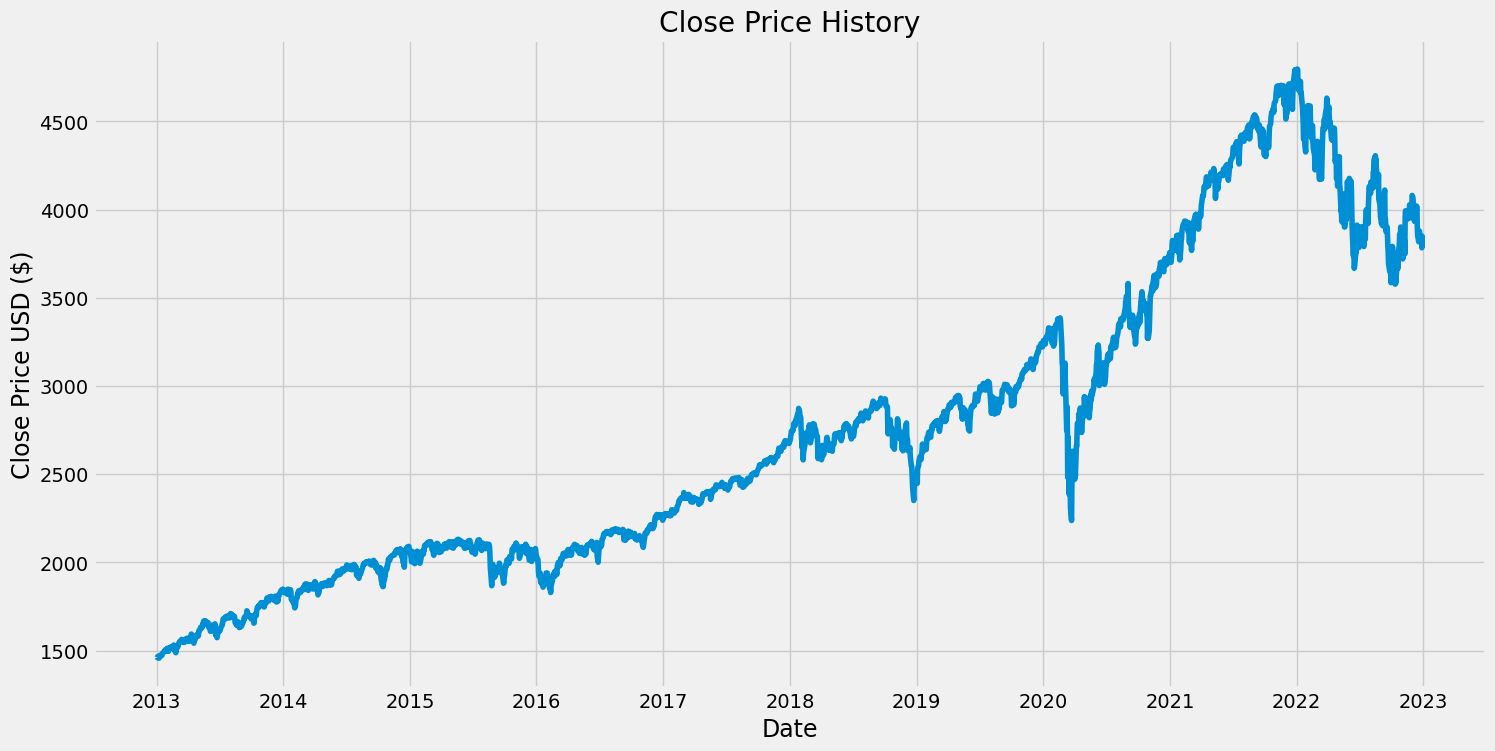

In [76]:
# Create a figure for the plot with a specific size
plt.figure(figsize=(16, 8))

# Set the title for the plot
plt.title('Close Price History')

# Plot the closing prices over time
plt.plot(df['Close'])

# Label the x-axis and y-axis
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Display the plot
plt.show()

In [77]:
# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Determine the number of rows for training the model (usually 80% of the data)
training_data_len = math.ceil(len(dataset) * 0.8)

# Print the calculated training data length
training_data_len

2015

In [78]:
# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Print the scaled data
scaled_data

array([[1.57812891e-03],
       [6.64779311e-04],
       [2.79089605e-03],
       ...,
       [6.96551164e-01],
       [7.16333119e-01],
       [7.13404449e-01]])

In [79]:
# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Initialize empty lists for training data and labels
x_train = []  # Input sequences
y_train = []  # Corresponding output values

# Iterate through the data to create training sequences
for i in range(60, len(train_data)):
    # Create input sequence with the previous 60 data points
    x_train.append(train_data[i-60:i, 0])
    
    # Create the corresponding output value
    y_train.append(train_data[i, 0])

    # Print the input sequences and labels for the first two iterations
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.00157813, 0.00066478, 0.0027909 , 0.00141941, 0.        ,
       0.00115889, 0.00448282, 0.00446187, 0.00405162, 0.00454869,
       0.00463554, 0.00712399, 0.00863325, 0.01060368, 0.01127745,
       0.01128041, 0.01371797, 0.01288552, 0.01517931, 0.01341852,
       0.01226563, 0.01677542, 0.01154693, 0.01621245, 0.01646098,
       0.01564348, 0.01820083, 0.01792532, 0.01865001, 0.01891949,
       0.01923393, 0.01875781, 0.02209669, 0.01641006, 0.01355629,
       0.01750308, 0.00919323, 0.01191525, 0.01761987, 0.0172276 ,
       0.01828165, 0.02037783, 0.02474689, 0.02524696, 0.02608544,
       0.02815768, 0.0296669 , 0.02854695, 0.02915784, 0.03176608,
       0.03100845, 0.02843315, 0.0273072 , 0.03041254, 0.02654661,
       0.02986755, 0.02831037, 0.03192779, 0.03165228, 0.03355081])]
[0.0314486746031018]

[array([0.00157813, 0.00066478, 0.0027909 , 0.00141941, 0.        ,
       0.00115889, 0.00448282, 0.00446187, 0.00405162, 0.00454869,
       0.00463554, 0.00712399, 0.008

In [80]:
# Convert the x_train and y_train lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [81]:
# Reshape the training data to match the input requirements of an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Print the shape of the reshaped training data
x_train.shape

(1955, 60, 1)

In [82]:
# Create an LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units and return sequences
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add the second LSTM layer with 50 units and do not return sequences
model.add(LSTM(50, return_sequences=False))

# Add a dense layer with 25 units
model.add(Dense(25))

# Add the output layer with a single unit for regression
model.add(Dense(1))

In [83]:
# Compile the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')

In [84]:
# Train the LSTM model with the training data
model.fit(x_train, y_train, batch_size=1, epochs=1)

1955/1955 [==============================] - 15s 7ms/step - loss: 0.0011


In [85]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Initialize empty lists for testing data and labels
x_test = []  # Input sequences
y_test = dataset[training_data_len:, :]  # Corresponding output values

# Iterate through the test data to create testing sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [86]:
# Convert the testing input data to a NumPy array
x_test = np.array(x_test)

In [87]:
# Reshape the testing input data to match the input requirements of the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [89]:
# Get the model's predicted price values for the test data
predictions = model.predict(x_test)

# Inverse transform the scaled predictions to their original scale
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 0s 5ms/step


In [90]:
# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

130.4142472959872

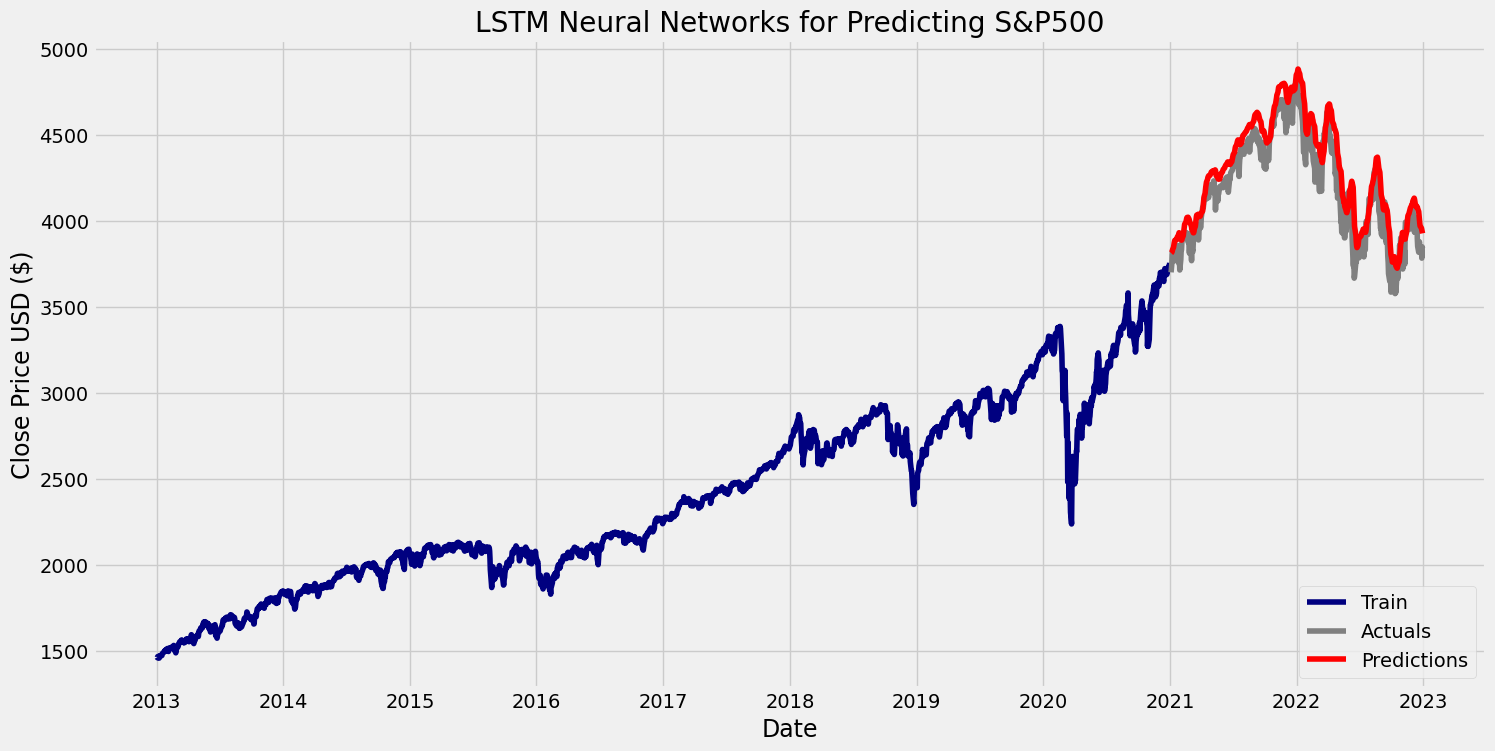

In [134]:
# Separate the data into training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()  # Create a copy to avoid the SettingWithCopyWarning
valid['Predictions'] = predictions  # Add predicted values to the 'valid' DataFrame

# Create a plot to visualize the data
plt.figure(figsize=(16, 8))
plt.title('LSTM Neural Networks for Predicting S&P500')
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Plot the 'Close' prices from the training data
plt.plot(train['Close'], label='Train', color='navy')

# Plot the 'Close' prices from the validation data
plt.plot(valid['Close'], label='Actuals', color='grey')

# Plot the 'Predictions' from the validation data
plt.plot(valid['Predictions'], label='Predictions', color='red')

# Add a legend to the plot
plt.legend(loc='lower right')

# Display the plot
plt.show()

In [93]:
# Display the DataFrame containing actual and predicted prices
valid

,Close,Predictions
2021-01-04,3700.649902,3812.738281
2021-01-05,3726.860107,3814.971191
2021-01-06,3748.139893,3816.949951
2021-01-07,3803.790039,3820.735596
2021-01-08,3824.679932,3831.115967
...,...,...
2022-12-23,3844.820068,3970.113525
2022-12-27,3829.250000,3957.460205
2022-12-28,3783.219971,3946.765137
2022-12-29,3849.280029,3933.326172


## Testing for statistical significance

In [116]:
# Get the model's predicted price values for the test data
predictions = model.predict(x_test)

# Inverse transform the scaled predictions to their original scale
predictions = scaler.inverse_transform(predictions)

# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance
rmse = np.sqrt(np.mean((predictions - y_test)**2))

# Print the RMSE to assess model performance
print(f"Root Mean Squared Error (RMSE): {rmse}")

16/16 [==============================] - 0s 5ms/step
Root Mean Squared Error (RMSE): 130.4142472959872


## Comparing the actual stock price with the predictions

In [135]:
import pandas as pd

# Assuming your DataFrame is already loaded as 'valid'
# You can calculate the cumulative percentage gain using the following code:

# Calculate the daily percentage change in the actual close prices
valid['Actual_Pct_Change'] = valid['Close'].pct_change() * 100

# Create a new column 'Buy_Sell' based on your prediction strategy
valid['Buy_Sell'] = valid['Predictions'] > valid['Close']

# Calculate the daily percentage gain based on your strategy
valid['Strategy_Pct_Change'] = valid['Buy_Sell'].shift(1) * valid['Actual_Pct_Change']

# Calculate the cumulative percentage gain for your strategy
valid['Cumulative_Strategy_Gain'] = (1 + valid['Strategy_Pct_Change'] / 100).cumprod() - 1

# Calculate the cumulative percentage gain if you kept the stock during the entire period
valid['Cumulative_Hold_Gain'] = (1 + valid['Actual_Pct_Change'] / 100).cumprod() - 1

# Print the last row of the DataFrame to get the final cumulative gains
final_cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].iloc[-1]
final_cumulative_hold_gain = valid['Cumulative_Hold_Gain'].iloc[-1]

print(f'Cumulative Percentage Gain with Strategy: {final_cumulative_strategy_gain:.2%}')
print(f'Cumulative Percentage Gain with Holding: {final_cumulative_hold_gain:.2%}')

Cumulative Percentage Gain with Strategy: 5.95%
Cumulative Percentage Gain with Holding: 3.75%


In [144]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming your DataFrame is already loaded as 'valid'
# You can calculate the cumulative percentage gain using the code mentioned earlier.

# Calculate the cumulative percentage gain for the strategy and holding
cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].iloc[-1]
cumulative_hold_gain = valid['Cumulative_Hold_Gain'].iloc[-1]

# Calculate the daily percentage gain for the entire period for both cases
strategy_pct_change = valid['Strategy_Pct_Change'].dropna()
hold_pct_change = valid['Actual_Pct_Change'].dropna()

# Filter out non-numeric and missing values
strategy_pct_change = strategy_pct_change.apply(pd.to_numeric, errors='coerce').dropna()
hold_pct_change = hold_pct_change.apply(pd.to_numeric, errors='coerce').dropna()

# Perform a two-sample t-test to test if the difference is statistically significant
t_stat, p_value = stats.ttest_ind(strategy_pct_change, hold_pct_change)

alpha = 0.05  # Significance level

# Check if the p-value is less than alpha to determine statistical significance
if p_value < alpha:
    print(f'The difference in gains is statistically significant (p-value={p_value:.4f}).')
else:
    print(f'The difference in gains is not statistically significant (p-value={p_value:.4f}).')

# Print the final cumulative gains
print(f'Cumulative Percentage Gain with Strategy: {cumulative_strategy_gain:.2%}')
print(f'Cumulative Percentage Gain with Holding: {cumulative_hold_gain:.2%}')

The difference in gains is not statistically significant (p-value=0.9628).
Cumulative Percentage Gain with Strategy: 5.95%
Cumulative Percentage Gain with Holding: 3.75%


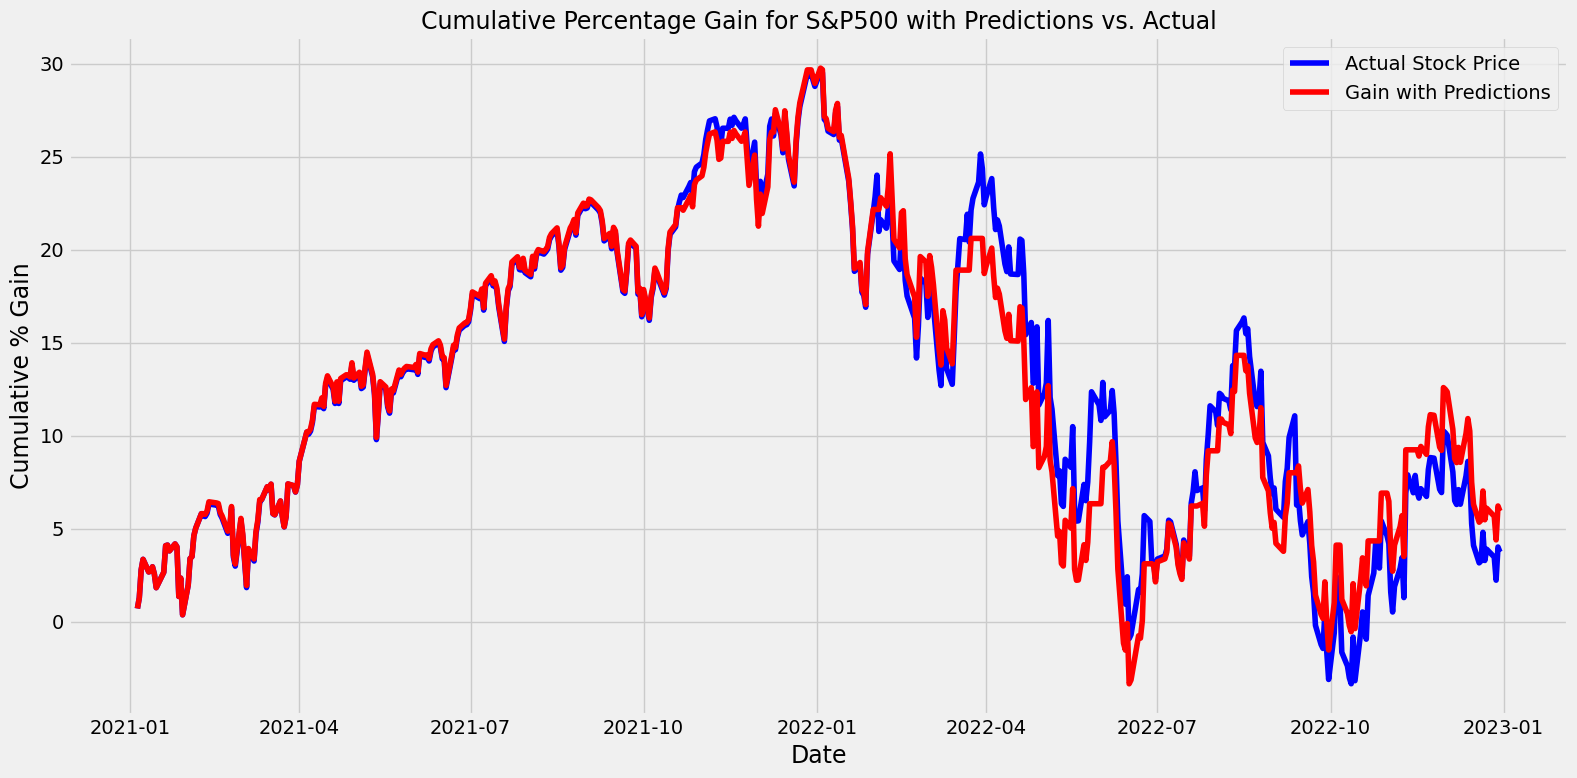

In [141]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the cumulative percentage gain for the actual stock price
ax.plot(valid.index, valid['Cumulative_Hold_Gain'] * 100, label='Actual Stock Price', color='blue')

# Plot the cumulative percentage gain with predictions
ax.plot(valid.index, valid['Cumulative_Strategy_Gain'] * 100, label='Gain with Predictions', color='red')

# Set labels and title with a font size of 17
ax.set_xlabel('Date', fontsize=17)
ax.set_ylabel('Cumulative % Gain', fontsize=17)
ax.set_title('Cumulative Percentage Gain for S&P500 with Predictions vs. Actual', fontsize=17)

# Add a legend
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()